# 🧱 DCGAN - 블록 데이터

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2025-07-29 07:38:50--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2025-07-29 07:38:51 (38.4 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 레고 블록 데이터셋에서 DCGAN을 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. 데이터 준비 <a name="prepare"></a>

In [10]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # # 캐글-->Setttings-->API-->Create New Token에서
    # # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    # from google.colab import files
    # files.upload()
    # !mkdir ~/.kaggle
    # !cp kaggle.json ~/.kaggle/
    # !chmod 600 ~/.kaggle/kaggle.json
    # 데이터셋을 다운로드하고 압축을 해제합니다.
    !kaggle datasets download -d joosthazelzet/lego-brick-images
    #
    # 캐글에서 다운로드가 안 될 경우 역자의 드라이브에서 다운로드할 수 있습니다.
    # import gdown
    # gdown.download(id='1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ')
    !unzip -q lego-brick-images.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

In [11]:
train_data = utils.image_dataset_from_directory(
    "./dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


In [12]:
def preprocess(img):
    """
    이미지 정규화 및 크기 변경
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [13]:
train_sample = sample_batch(train)

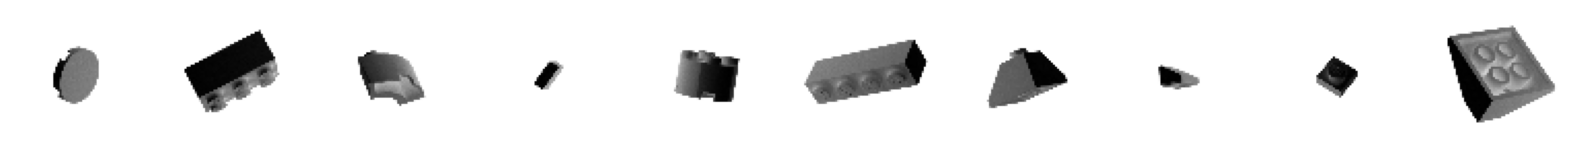

In [14]:
display(train_sample)

## 2. GAN 구축 <a name="build"></a>

In [15]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 1)      │         1,024 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs):
        return self.generator(inputs)

In [26]:
# DCGAN 생성
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [ ]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. GAN 훈련 <a name="train"></a>

In [27]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [28]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - d_acc: 0.8747 - d_fake_acc: 0.8750 - d_loss: 0.4284 - d_real_acc: 0.8744 - g_acc: 0.1250 - g_loss: 2.4129
Saved to ./output/generated_img_000.png


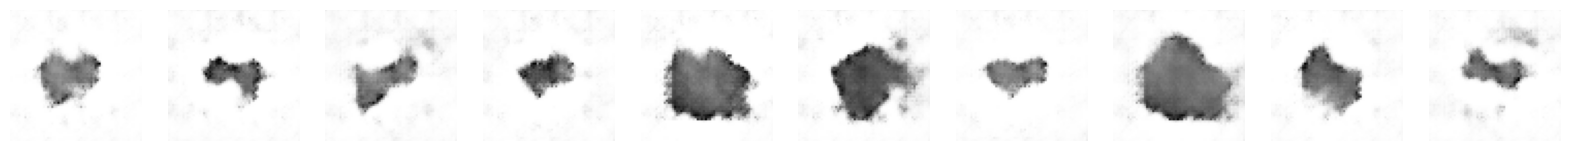

313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - d_acc: 0.8747 - d_fake_acc: 0.8750 - d_loss: 0.4284 - d_real_acc: 0.8744 - g_acc: 0.1250 - g_loss: 2.4128
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - d_acc: 0.8698 - d_fake_acc: 0.8681 - d_loss: 0.4192 - d_real_acc: 0.8715 - g_acc: 0.1319 - g_loss: 2.1080
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 183ms/step - d_acc: 0.8771 - d_fake_acc: 0.8781 - d_loss: 0.4061 - d_real_acc: 0.8760 - g_acc: 0.1219 - g_loss: 2.2080
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - d_acc: 0.8835 - d_fake_acc: 0.8796 - d_loss: 0.3948 - d_real_acc: 0.8873 - g_acc: 0.1204 - g_loss: 2.1072
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - d_acc: 0.8814 - d_fake_acc: 0.8823 - d_loss: 0.3981 - d_real_acc: 0.8805 - g_acc: 0.1177 - g_loss: 2.2148
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - d_acc: 0.9108 - d_fake_acc: 0.9092 - d_loss: 0.3628 - d_real_acc: 0.9125 - g_acc: 0.0908 - g_loss: 2.2568
Epoch 7/100
313/313 ━━━━━━━━

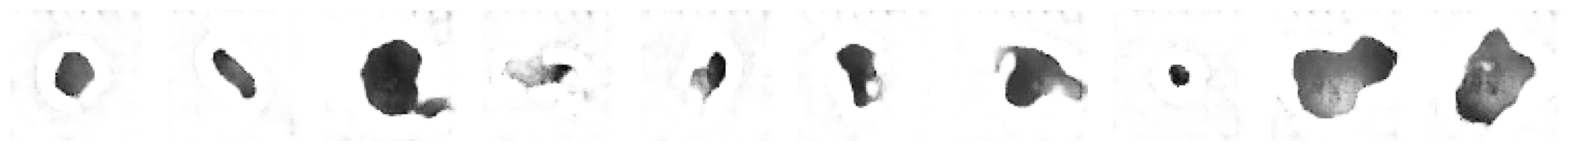

313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 341ms/step - d_acc: 0.9191 - d_fake_acc: 0.9206 - d_loss: 0.3490 - d_real_acc: 0.9176 - g_acc: 0.0794 - g_loss: 2.3001
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 180ms/step - d_acc: 0.9063 - d_fake_acc: 0.9048 - d_loss: 0.3646 - d_real_acc: 0.9078 - g_acc: 0.0952 - g_loss: 2.2823
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - d_acc: 0.9019 - d_fake_acc: 0.9008 - d_loss: 0.3689 - d_real_acc: 0.9031 - g_acc: 0.0992 - g_loss: 2.2648
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - d_acc: 0.9246 - d_fake_acc: 0.9256 - d_loss: 0.3382 - d_real_acc: 0.9236 - g_acc: 0.0744 - g_loss: 2.4648
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - d_acc: 0.9463 - d_fake_acc: 0.9466 - d_loss: 0.3127 - d_real_acc: 0.9460 - g_acc: 0.0534 - g_loss: 2.4148
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - d_acc: 0.9308 - d_fake_acc: 0.9320 - d_loss: 0.3288 - d_real_acc: 0.9296 - g_acc: 0.0680 - g_loss: 2.4665
Epoch 17/100
313/313 ━

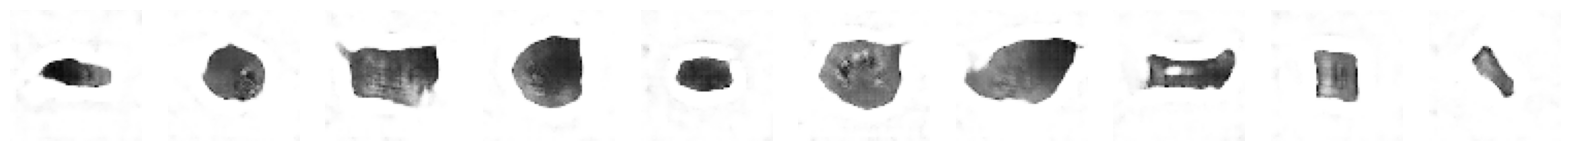

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 179ms/step - d_acc: 0.9452 - d_fake_acc: 0.9470 - d_loss: 0.3099 - d_real_acc: 0.9434 - g_acc: 0.0530 - g_loss: 2.6132
Epoch 22/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 183ms/step - d_acc: 0.9261 - d_fake_acc: 0.9279 - d_loss: 0.3346 - d_real_acc: 0.9244 - g_acc: 0.0721 - g_loss: 2.5126
Epoch 23/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 179ms/step - d_acc: 0.9517 - d_fake_acc: 0.9550 - d_loss: 0.3003 - d_real_acc: 0.9483 - g_acc: 0.0450 - g_loss: 2.6462
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 179ms/step - d_acc: 0.9486 - d_fake_acc: 0.9500 - d_loss: 0.3030 - d_real_acc: 0.9473 - g_acc: 0.0500 - g_loss: 2.6584
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - d_acc: 0.9580 - d_fake_acc: 0.9587 - d_loss: 0.2941 - d_real_acc: 0.9573 - g_acc: 0.0413 - g_loss: 2.7068
Epoch 26/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 179ms/step - d_acc: 0.9209 - d_fake_acc: 0.9225 - d_loss: 0.3388 - d_real_acc: 0.9193 - g_acc: 0.0775 - g_loss: 2.3859
Epoch 27/100
313/313 ━━

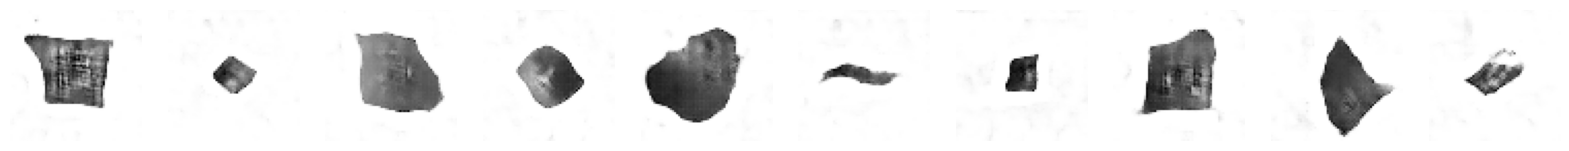

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - d_acc: 0.9677 - d_fake_acc: 0.9700 - d_loss: 0.2803 - d_real_acc: 0.9654 - g_acc: 0.0300 - g_loss: 2.6790
Epoch 32/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - d_acc: 0.9555 - d_fake_acc: 0.9568 - d_loss: 0.2930 - d_real_acc: 0.9541 - g_acc: 0.0432 - g_loss: 2.7625
Epoch 33/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - d_acc: 0.9524 - d_fake_acc: 0.9552 - d_loss: 0.2999 - d_real_acc: 0.9496 - g_acc: 0.0448 - g_loss: 2.6259
Epoch 34/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - d_acc: 0.9559 - d_fake_acc: 0.9573 - d_loss: 0.2938 - d_real_acc: 0.9546 - g_acc: 0.0427 - g_loss: 2.6610
Epoch 35/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - d_acc: 0.9196 - d_fake_acc: 0.9255 - d_loss: 0.3451 - d_real_acc: 0.9138 - g_acc: 0.0745 - g_loss: 2.4672
Epoch 36/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - d_acc: 0.9527 - d_fake_acc: 0.9562 - d_loss: 0.3000 - d_real_acc: 0.9492 - g_acc: 0.0438 - g_loss: 2.7180
Epoch 37/100
313/313 ━━

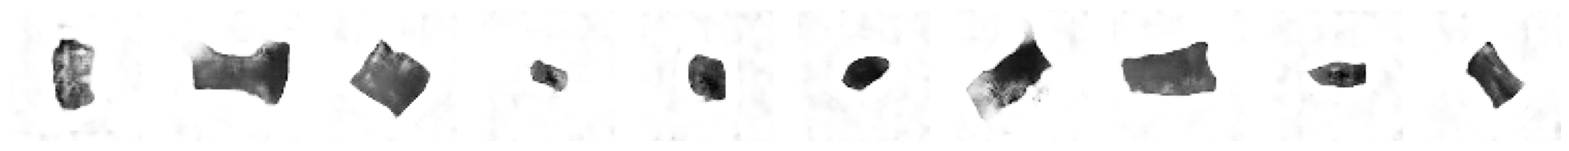

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - d_acc: 0.9551 - d_fake_acc: 0.9553 - d_loss: 0.2995 - d_real_acc: 0.9550 - g_acc: 0.0447 - g_loss: 2.6984
Epoch 42/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - d_acc: 0.9744 - d_fake_acc: 0.9747 - d_loss: 0.2682 - d_real_acc: 0.9741 - g_acc: 0.0253 - g_loss: 2.8181
Epoch 43/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - d_acc: 0.9684 - d_fake_acc: 0.9683 - d_loss: 0.2820 - d_real_acc: 0.9686 - g_acc: 0.0317 - g_loss: 2.8712
Epoch 44/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - d_acc: 0.9819 - d_fake_acc: 0.9819 - d_loss: 0.2594 - d_real_acc: 0.9819 - g_acc: 0.0181 - g_loss: 2.8511
Epoch 45/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - d_acc: 0.9302 - d_fake_acc: 0.9290 - d_loss: 0.3389 - d_real_acc: 0.9313 - g_acc: 0.0710 - g_loss: 2.6254
Epoch 46/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - d_acc: 0.9841 - d_fake_acc: 0.9843 - d_loss: 0.2571 - d_real_acc: 0.9839 - g_acc: 0.0157 - g_loss: 2.8808
Epoch 47/100
313/313 ━━

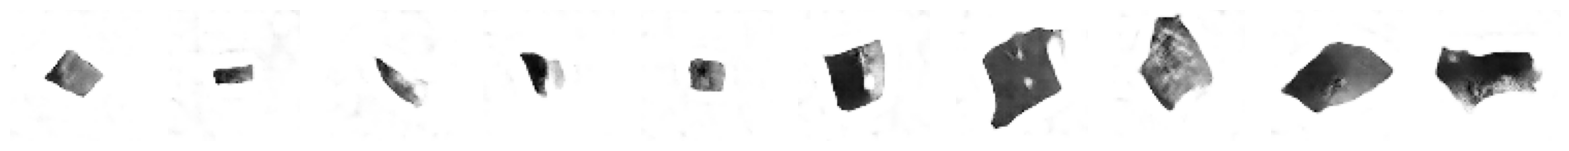

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - d_acc: 0.9661 - d_fake_acc: 0.9667 - d_loss: 0.2789 - d_real_acc: 0.9655 - g_acc: 0.0333 - g_loss: 2.8697
Epoch 52/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - d_acc: 0.9788 - d_fake_acc: 0.9790 - d_loss: 0.2643 - d_real_acc: 0.9787 - g_acc: 0.0210 - g_loss: 2.9376
Epoch 53/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - d_acc: 0.9590 - d_fake_acc: 0.9576 - d_loss: 0.2892 - d_real_acc: 0.9604 - g_acc: 0.0424 - g_loss: 2.8018
Epoch 54/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - d_acc: 0.9776 - d_fake_acc: 0.9778 - d_loss: 0.2637 - d_real_acc: 0.9773 - g_acc: 0.0222 - g_loss: 2.8971
Epoch 55/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - d_acc: 0.9744 - d_fake_acc: 0.9750 - d_loss: 0.2722 - d_real_acc: 0.9737 - g_acc: 0.0250 - g_loss: 2.9192
Epoch 56/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - d_acc: 0.9003 - d_fake_acc: 0.8958 - d_loss: 0.3993 - d_real_acc: 0.9047 - g_acc: 0.1042 - g_loss: 2.5796
Epoch 57/100
313/313 ━━

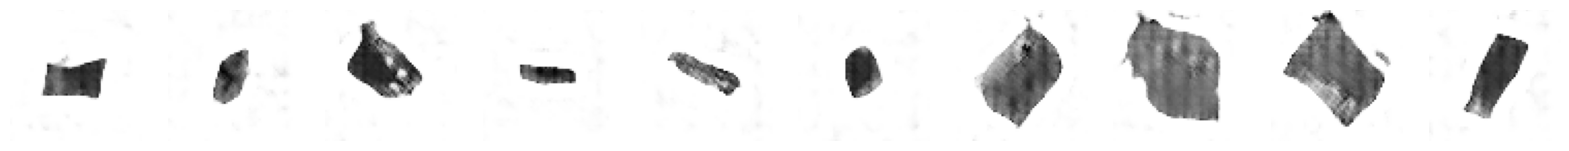

313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - d_acc: 0.9735 - d_fake_acc: 0.9758 - d_loss: 0.2709 - d_real_acc: 0.9713 - g_acc: 0.0242 - g_loss: 2.8429
Epoch 62/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - d_acc: 0.9528 - d_fake_acc: 0.9532 - d_loss: 0.2986 - d_real_acc: 0.9524 - g_acc: 0.0468 - g_loss: 2.6831
Epoch 63/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - d_acc: 0.9670 - d_fake_acc: 0.9683 - d_loss: 0.2778 - d_real_acc: 0.9657 - g_acc: 0.0317 - g_loss: 2.7943
Epoch 64/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - d_acc: 0.9716 - d_fake_acc: 0.9712 - d_loss: 0.2755 - d_real_acc: 0.9719 - g_acc: 0.0288 - g_loss: 2.8975
Epoch 65/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 188ms/step - d_acc: 0.9639 - d_fake_acc: 0.9683 - d_loss: 0.2824 - d_real_acc: 0.9595 - g_acc: 0.0317 - g_loss: 2.8181
Epoch 66/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 183ms/step - d_acc: 0.9617 - d_fake_acc: 0.9597 - d_loss: 0.2864 - d_real_acc: 0.9637 - g_acc: 0.0403 - g_loss: 2.7678
Epoch 67/100
313/313 ━━

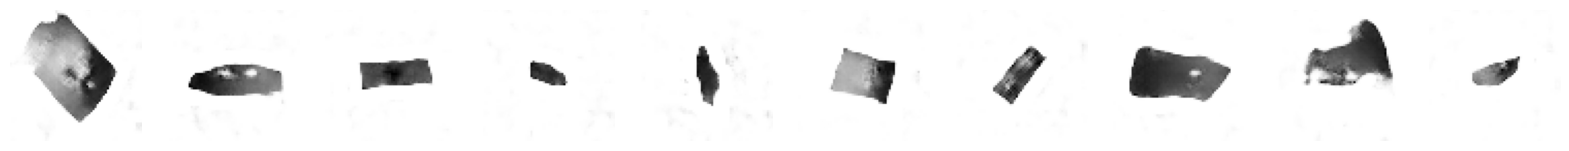

313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - d_acc: 0.9504 - d_fake_acc: 0.9517 - d_loss: 0.3010 - d_real_acc: 0.9492 - g_acc: 0.0483 - g_loss: 2.7145
Epoch 72/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 186ms/step - d_acc: 0.9787 - d_fake_acc: 0.9775 - d_loss: 0.2626 - d_real_acc: 0.9799 - g_acc: 0.0225 - g_loss: 2.8711
Epoch 73/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - d_acc: 0.9713 - d_fake_acc: 0.9711 - d_loss: 0.2734 - d_real_acc: 0.9716 - g_acc: 0.0289 - g_loss: 2.8402
Epoch 74/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 186ms/step - d_acc: 0.9827 - d_fake_acc: 0.9842 - d_loss: 0.2592 - d_real_acc: 0.9812 - g_acc: 0.0158 - g_loss: 2.9605
Epoch 75/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - d_acc: 0.8580 - d_fake_acc: 0.8519 - d_loss: 0.4648 - d_real_acc: 0.8640 - g_acc: 0.1481 - g_loss: 2.4395
Epoch 76/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - d_acc: 0.9836 - d_fake_acc: 0.9832 - d_loss: 0.2574 - d_real_acc: 0.9840 - g_acc: 0.0168 - g_loss: 2.8328
Epoch 77/100
313/313 ━━

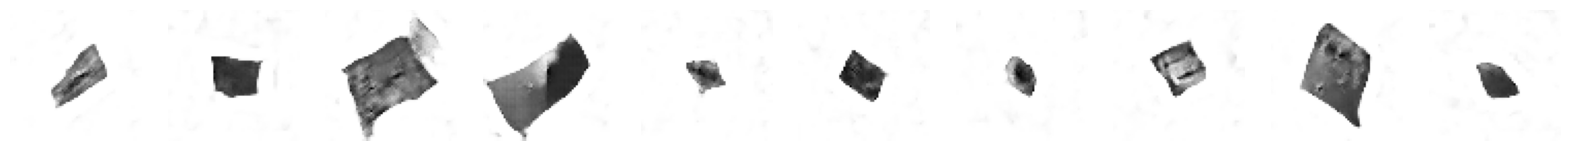

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - d_acc: 0.9755 - d_fake_acc: 0.9770 - d_loss: 0.2659 - d_real_acc: 0.9740 - g_acc: 0.0230 - g_loss: 2.8786
Epoch 82/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - d_acc: 0.9410 - d_fake_acc: 0.9378 - d_loss: 0.3204 - d_real_acc: 0.9442 - g_acc: 0.0622 - g_loss: 2.7570
Epoch 83/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - d_acc: 0.9663 - d_fake_acc: 0.9658 - d_loss: 0.2827 - d_real_acc: 0.9667 - g_acc: 0.0342 - g_loss: 2.8430
Epoch 84/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - d_acc: 0.9848 - d_fake_acc: 0.9849 - d_loss: 0.2562 - d_real_acc: 0.9847 - g_acc: 0.0151 - g_loss: 2.9458
Epoch 85/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - d_acc: 0.9271 - d_fake_acc: 0.9296 - d_loss: 0.3262 - d_real_acc: 0.9247 - g_acc: 0.0704 - g_loss: 2.6802
Epoch 86/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - d_acc: 0.9670 - d_fake_acc: 0.9642 - d_loss: 0.2817 - d_real_acc: 0.9698 - g_acc: 0.0358 - g_loss: 2.8145
Epoch 87/100
313/313 ━━

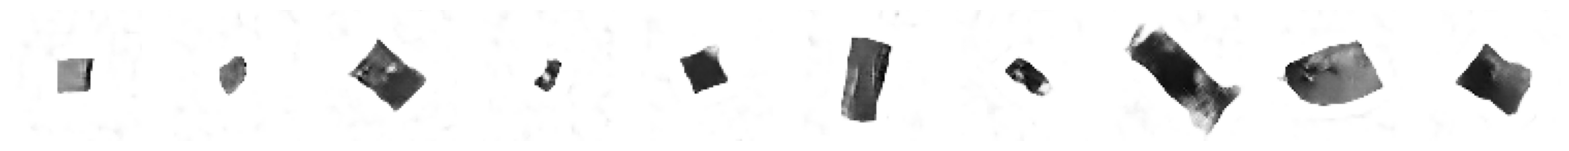

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - d_acc: 0.9739 - d_fake_acc: 0.9746 - d_loss: 0.2672 - d_real_acc: 0.9732 - g_acc: 0.0254 - g_loss: 2.8827
Epoch 92/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - d_acc: 0.9695 - d_fake_acc: 0.9650 - d_loss: 0.2893 - d_real_acc: 0.9739 - g_acc: 0.0350 - g_loss: 2.9281
Epoch 93/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - d_acc: 0.9803 - d_fake_acc: 0.9844 - d_loss: 0.2611 - d_real_acc: 0.9762 - g_acc: 0.0156 - g_loss: 2.9428
Epoch 94/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - d_acc: 0.9857 - d_fake_acc: 0.9852 - d_loss: 0.2524 - d_real_acc: 0.9862 - g_acc: 0.0148 - g_loss: 3.0015
Epoch 95/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - d_acc: 0.9090 - d_fake_acc: 0.9164 - d_loss: 0.3651 - d_real_acc: 0.9016 - g_acc: 0.0836 - g_loss: 2.7192
Epoch 96/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - d_acc: 0.9801 - d_fake_acc: 0.9814 - d_loss: 0.2613 - d_real_acc: 0.9788 - g_acc: 0.0186 - g_loss: 2.9564
Epoch 97/100
313/313 ━━

In [29]:
# Build the DCGAN model by calling it on a dummy input
dummy_input = tf.random.normal(shape=(BATCH_SIZE, Z_DIM))
dcgan(dummy_input)

dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [32]:
# 최종 모델 저장
generator.save("./generator.keras")
discriminator.save("./discriminator.keras")

## 3. 새로운 이미지 생성 <a name="decode"></a>

In [33]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [34]:
# 샘플링된 포인트 디코딩
reconstructions = generator.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


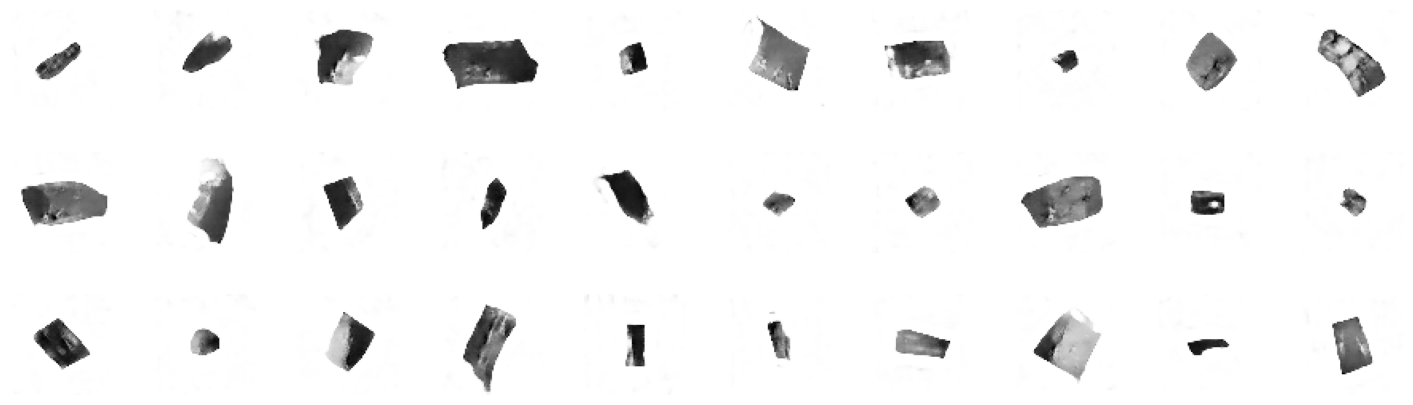

In [35]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [36]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [37]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


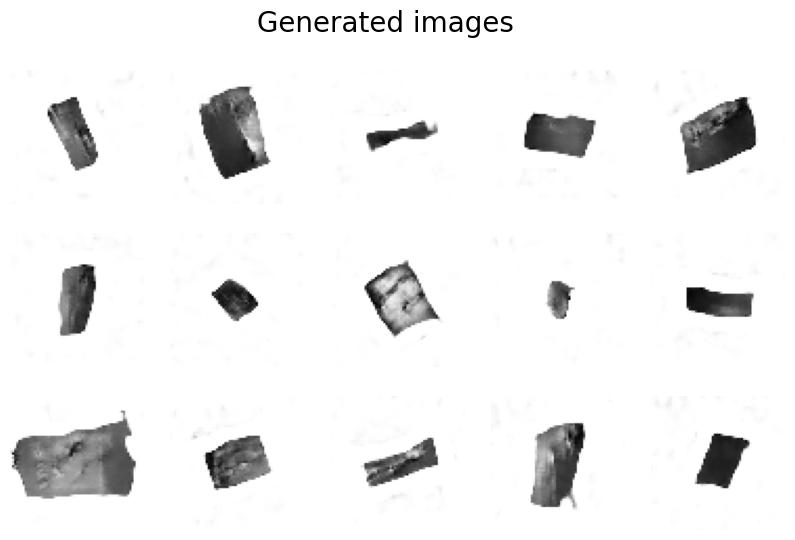

In [38]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

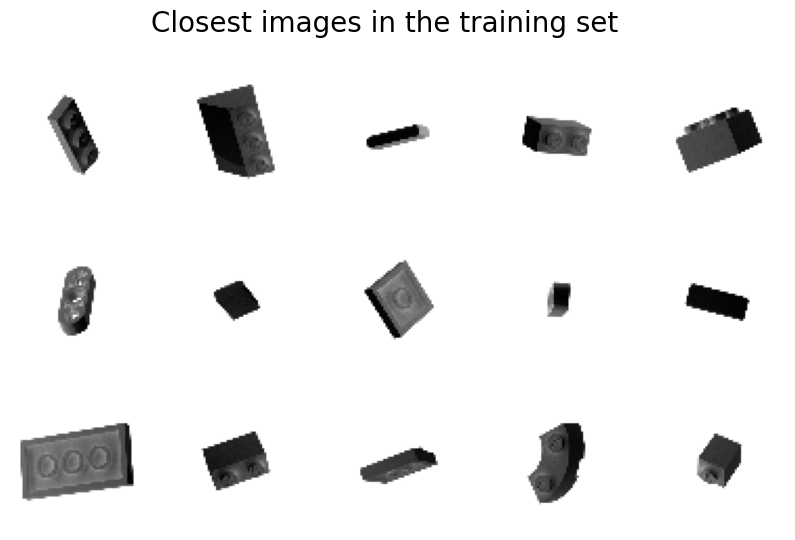

In [39]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()